In [ ]:
# Import necessary libraries
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import glob
import cv2
import os
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, concatenate
from keras.preprocessing.image import load_img, img_to_array
from babel.numbers import format_currency
from skimage.transform import resize

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load house attributes from the CSV file
file_path = '/content/gdrive/MyDrive/pfa/data.csv'
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

# Use the default delimiter (comma) and include column headers
df = pd.read_csv(file_path, header=None, names=cols, skiprows=1)

# Display the first few rows for verification
print(df.head())

# Display the data type of each column
print(df.dtypes)

# Display the final number of rows in the DataFrame
final_row_count = len(df)
print("Final number of rows in the DataFrame:", final_row_count)


   bedrooms  bathrooms  area  zipcode   price
1         4        4.0  4053    85255  869500
2         4        3.0  3343    36372  865200
3         3        4.0  3923    85266  889000
4         5        5.0  4022    85262  910000
5         3        4.0  4116    85266  971226
bedrooms       int64
bathrooms    float64
area           int64
zipcode        int64
price          int64
dtype: object
Final number of rows in the DataFrame: 535


<class 'pandas.core.frame.DataFrame'>
Index: 535 entries, 1 to 535
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   535 non-null    int64  
 1   bathrooms  535 non-null    float64
 2   area       535 non-null    int64  
 3   zipcode    535 non-null    int64  
 4   price      535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 25.1 KB
None


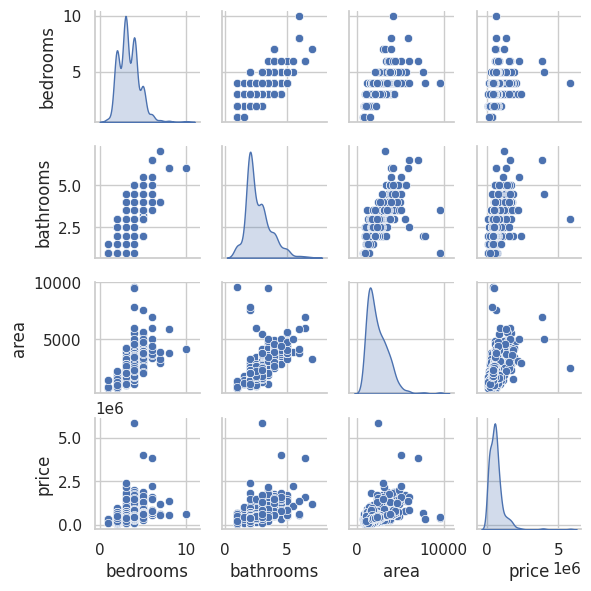

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the file path
file_path = '/content/gdrive/MyDrive/pfa/data.csv'

# Define the columns names
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

# Read the CSV file with specific column names, skipping the first row
df = pd.read_csv(file_path, header=None, names=cols, skiprows=1)

# Convert price to numeric if not already, and handle non-numeric entries
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN values
df = df.dropna()

# Display updated DataFrame info
print(df.info())

# Visualization

# Set the style of seaborn
sns.set(style="whitegrid")

# Smaller pairplot to visualize relationships between numeric variables
pairplot = sns.pairplot(df, vars=["bedrooms", "bathrooms", "area", "price"], diag_kind='kde', height=1.5)

# Save the pairplot to a file
pairplot.savefig("/content/gdrive/MyDrive/pfa/small_pairplot.png")

# Show the plot
plt.show()


In [ ]:
# Preprocessing house attributes
from sklearn.impute import KNNImputer

# List of continuous columns
continuous_columns = ["bedrooms", "bathrooms", "area", "zipcode"]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Convert continuous columns to numeric type
df[continuous_columns] = df[continuous_columns].apply(pd.to_numeric, errors='coerce')

# Create a KNN imputer
imputer = KNNImputer(n_neighbors=2)

# Apply KNN imputation to continuous columns
df[continuous_columns] = imputer.fit_transform(df[continuous_columns])

# Display the first few rows for verification
print(df.head())

   bedrooms  bathrooms    area  zipcode   price
1       4.0        4.0  4053.0  85255.0  869500
2       4.0        3.0  3343.0  36372.0  865200
3       3.0        4.0  3923.0  85266.0  889000
4       5.0        5.0  4022.0  85262.0  910000
5       3.0        4.0  4116.0  85266.0  971226


In [ ]:
# Apply MinMaxScaler to continuous columns
if not df[continuous_columns].empty:
    df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
else:
    print("No data available for MinMaxScaler. Please check your data.")

# Display the first few rows for verification
print(df.head())


   bedrooms  bathrooms      area   zipcode   price
1  0.333333   0.500000  0.377392  0.792924  869500
2  0.333333   0.333333  0.297456  0.000000  865200
3  0.222222   0.500000  0.362756  0.793103  889000
4  0.444444   0.666667  0.373902  0.793038  910000
5  0.222222   0.500000  0.384485  0.793103  971226


In [ ]:
# Select the "price" column and perform scaling
df["price"] = scaler.fit_transform(df[["price"]])

# Display the first few rows for verification
print(df.head())


   bedrooms  bathrooms      area   zipcode     price
1  0.333333   0.500000  0.377392  0.792924  0.145219
2  0.333333   0.333333  0.297456  0.000000  0.144483
3  0.222222   0.500000  0.362756  0.793103  0.148561
4  0.444444   0.666667  0.373902  0.793038  0.152159
5  0.222222   0.500000  0.384485  0.793103  0.162650


In [ ]:
# Data partitioning
split = train_test_split(df, test_size=0.25, random_state=42)
(trainAttrX, testAttrX) = split

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

• Deciding on the network topology

Training with architecture = [8]
Training with architecture = [8, 4]
Training with architecture = [16, 8, 4]
Best model (architecture = [8]) with minimal validation loss (MAE): 0.0386776439845562
Best model (architecture = [8]) with minimal validation RMSE: 0.05567551404237747


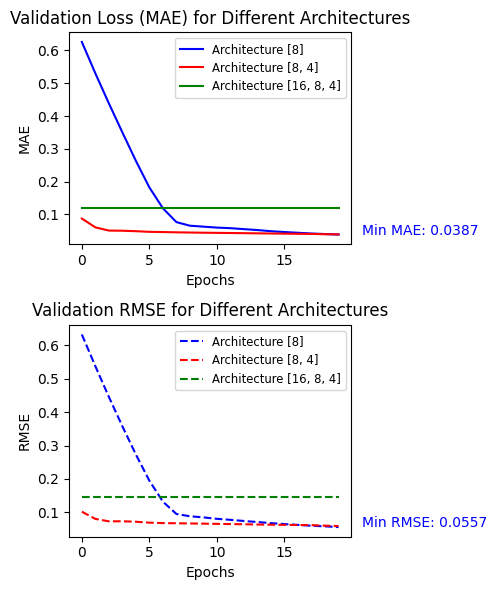

In [ ]:
from tensorflow.keras import Input, layers, Model, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the architectures to be tested (number of layers)
architectures = [
    [8],
    [8, 4],
    [16, 8, 4]
]

colors = ['blue', 'red', 'green']  # Colors for each architecture

# Initialize variables for the best model
best_model = None
best_loss_mae = float('inf')  # Initialize with infinity for MAE
best_loss_rmse = float('inf')  # Initialize with infinity for RMSE
best_architecture = None

# Create subplots for MAE and RMSE separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

for idx, architecture in enumerate(architectures):
    print(f"Training with architecture = {architecture}")

    # Define the model input
    mlp_input = Input(shape=(trainAttrX.shape[1],), name="mlp_input")

    # Define model layers based on the architecture
    x = mlp_input
    for i, units in enumerate(architecture):
        x = layers.Dense(units, activation="relu", name=f"mlp_dense_layer{i+1}")(x)

    # Define the model output
    mlp_output = layers.Dense(1, activation="relu", name="mlp_output")(x)

    # Create the complete model
    model = Model(inputs=mlp_input, outputs=mlp_output)

    # Create an Adam optimizer with a specified learning rate
    optimizer = optimizers.Adam(learning_rate=0.001)

    # Compile the model with MSE and RMSE as metrics
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mse', tf.keras.metrics.RootMeanSquaredError()])

    # Train the model
    history = model.fit(trainAttrX, trainY, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Plot the validation loss curve for this architecture with MAE
    ax1.plot(history.history['val_loss'], label=f'Architecture {architecture}', color=colors[idx])

    # Plot the validation RMSE curve for this architecture
    ax2.plot(history.history['val_root_mean_squared_error'], label=f'Architecture {architecture}', linestyle='--', color=colors[idx])

    # Get the final validation loss (MAE and RMSE)
    final_loss_mae = history.history['val_loss'][-1]
    final_loss_rmse = history.history['val_root_mean_squared_error'][-1]

    # Check if this model has the best MAE so far
    if final_loss_mae < best_loss_mae:
        best_loss_mae = final_loss_mae
        best_model = model
        best_architecture = architecture

    # Check if this model has the best RMSE so far
    if final_loss_rmse < best_loss_rmse:
        best_loss_rmse = final_loss_rmse

# Display the best model with its architecture and minimal validation losses
print(f"Best model (architecture = {best_architecture}) with minimal validation loss (MAE): {best_loss_mae}")
print(f"Best model (architecture = {best_architecture}) with minimal validation RMSE: {best_loss_rmse}")

# Annotate the minimal MAE and RMSE values on the plots
ax1.annotate(f'Min MAE: {best_loss_mae:.4f}', xy=(1, best_loss_mae), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color='blue')
ax2.annotate(f'Min RMSE: {best_loss_rmse:.4f}', xy=(1, best_loss_rmse), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color='blue')

# Configure the first plot (MAE) with legend
ax1.set_title('Validation Loss (MAE) for Different Architectures')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')
ax1.legend(loc='upper right', fontsize='small')
ax1.grid(False)

# Configure the second plot (RMSE) with legend
ax2.set_title('Validation RMSE for Different Architectures')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('RMSE')
ax2.legend(loc='upper right', fontsize='small')
ax2.grid(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


• Adjusting optimizer:Learning rate

Training with learning rate = 0.001
Training with learning rate = 0.01
Training with learning rate = 0.1
Best model (learning rate = 0.01) with minimal validation loss (MAE): 0.0034473533742129803
Best model (learning rate = 0.01) with minimal validation RMSE: 0.007926277816295624


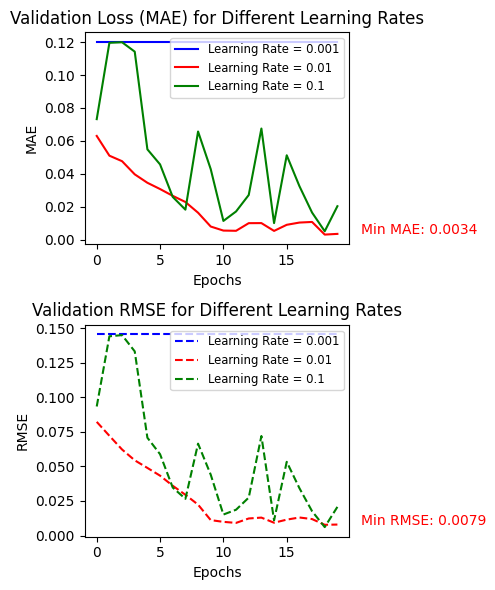

In [ ]:
from tensorflow.keras import Input, layers, Model, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the fixed architecture to be tested (number of layers)
architecture = [8]

# Define the learning rates to be tested
learning_rates = [0.001, 0.01, 0.1]

colors = ['blue', 'red', 'green']  # Colors for each learning rate

# Initialize variables for the best model with fixed architecture
best_model = None
best_loss_mae = float('inf')  # Initialize with infinity for MAE
best_loss_rmse = float('inf')  # Initialize with infinity for RMSE
best_learning_rate = None
best_color = None  # Variable to store color of the best model

# Create subplots for MAE and RMSE separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

for lr_idx, lr in enumerate(learning_rates):
    print(f"Training with learning rate = {lr}")

    # Define the model input
    mlp_input = Input(shape=(trainAttrX.shape[1],), name="mlp_input")

    # Define model layers based on the fixed architecture
    x = mlp_input
    for i, units in enumerate(architecture):
        x = layers.Dense(units, activation="relu", name=f"mlp_dense_layer{i+1}")(x)

    # Define the model output
    mlp_output = layers.Dense(1, activation="relu", name="mlp_output")(x)

    # Create the complete model
    model = Model(inputs=mlp_input, outputs=mlp_output)

    # Create an Adam optimizer with the current learning rate
    optimizer = optimizers.Adam(learning_rate=lr)

    # Compile the model with MSE and RMSE as metrics
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mse', tf.keras.metrics.RootMeanSquaredError()])

    # Train the model
    history = model.fit(trainAttrX, trainY, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

    # Plot the validation loss curve for this learning rate with MAE
    line1, = ax1.plot(history.history['val_loss'], label=f'Learning Rate = {lr}', color=colors[lr_idx])

    # Plot the validation RMSE curve for this learning rate
    line2, = ax2.plot(history.history['val_root_mean_squared_error'], label=f'Learning Rate = {lr}', linestyle='--', color=colors[lr_idx])

    # Get the final validation loss (MAE and RMSE)
    final_loss_mae = history.history['val_loss'][-1]
    final_loss_rmse = history.history['val_root_mean_squared_error'][-1]

    # Check if this model with the current learning rate has the best MAE so far
    if final_loss_mae < best_loss_mae:
        best_loss_mae = final_loss_mae
        best_model = model
        best_learning_rate = lr
        best_color = colors[lr_idx]  # Capture the color of the best model

    # Check if this model with the current learning rate has the best RMSE so far
    if final_loss_rmse < best_loss_rmse:
        best_loss_rmse = final_loss_rmse

# Display the best model with its learning rate and minimal validation losses
print(f"Best model (learning rate = {best_learning_rate}) with minimal validation loss (MAE): {best_loss_mae}")
print(f"Best model (learning rate = {best_learning_rate}) with minimal validation RMSE: {best_loss_rmse}")

# Annotate the minimal MAE and RMSE values on the plots with the color of the best model
ax1.annotate(f'Min MAE: {best_loss_mae:.4f}', xy=(1, best_loss_mae), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color=best_color)
ax2.annotate(f'Min RMSE: {best_loss_rmse:.4f}', xy=(1, best_loss_rmse), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color=best_color)

# Configure the first plot (MAE) with legend
ax1.set_title('Validation Loss (MAE) for Different Learning Rates')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')
ax1.legend(loc='upper right', fontsize='small')
ax1.grid(False)

# Configure the second plot (RMSE) with legend
ax2.set_title('Validation RMSE for Different Learning Rates')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('RMSE')
ax2.legend(loc='upper right', fontsize='small')
ax2.grid(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()





Deciding on the batch size

Training with batch size = 16
Training with batch size = 32
Training with batch size = 64
Best model (batch size = 16) with minimal validation loss (MAE): 0.12494532018899918
Best model (batch size = 16) with minimal validation RMSE: 0.1492663472890854


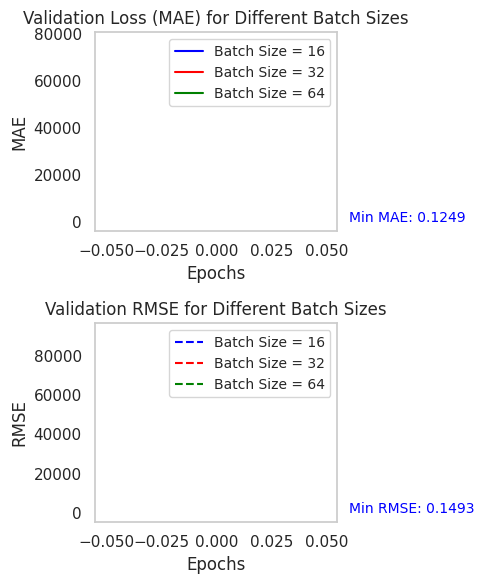

In [ ]:
from tensorflow.keras import Input, layers, Model, optimizers
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the fixed architecture to be tested (number of layers)
architecture = [8]

# Define the fixed learning rate
learning_rate = 0.01

# Define the batch sizes to be tested
batch_sizes = [16, 32, 64]

colors = ['blue', 'red', 'green']  # Colors for each batch size

# Initialize variables for the best model with fixed architecture and learning rate
best_model = None
best_loss_mae = float('inf')  # Initialize with infinity for MAE
best_loss_rmse = float('inf')  # Initialize with infinity for RMSE
best_batch_size = None
best_color = None  # Variable to store color of the best model

# Create subplots for MAE and RMSE separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

for bs_idx, batch_size in enumerate(batch_sizes):
    print(f"Training with batch size = {batch_size}")

    # Define the model input
    mlp_input = Input(shape=(trainAttrX.shape[1],), name="mlp_input")

    # Define model layers based on the fixed architecture
    x = mlp_input
    for i, units in enumerate(architecture):
        x = layers.Dense(units, activation="relu", name=f"mlp_dense_layer{i+1}")(x)

    # Define the model output
    mlp_output = layers.Dense(1, activation="relu", name="mlp_output")(x)

    # Create the complete model
    model = Model(inputs=mlp_input, outputs=mlp_output)

    # Create an Adam optimizer with the fixed learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with MSE and RMSE as metrics
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mse', tf.keras.metrics.RootMeanSquaredError()])

    # Train the model with the current batch size
    history = model.fit(trainAttrX, trainY, epochs=1, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Plot the validation loss curve for this batch size with MAE
    line1, = ax1.plot(history.history['val_loss'], label=f'Batch Size = {batch_size}', color=colors[bs_idx])

    # Plot the validation RMSE curve for this batch size
    line2, = ax2.plot(history.history['val_root_mean_squared_error'], label=f'Batch Size = {batch_size}', linestyle='--', color=colors[bs_idx])

    # Get the final validation loss (MAE and RMSE)
    final_loss_mae = history.history['val_loss'][-1]
    final_loss_rmse = history.history['val_root_mean_squared_error'][-1]

    # Check if this model with the current batch size has the best MAE so far
    if final_loss_mae < best_loss_mae:
        best_loss_mae = final_loss_mae
        best_model = model
        best_batch_size = batch_size
        best_color = colors[bs_idx]  # Capture the color of the best model

    # Check if this model with the current batch size has the best RMSE so far
    if final_loss_rmse < best_loss_rmse:
        best_loss_rmse = final_loss_rmse

# Display the best model with its batch size and minimal validation losses
print(f"Best model (batch size = {best_batch_size}) with minimal validation loss (MAE): {best_loss_mae}")
print(f"Best model (batch size = {best_batch_size}) with minimal validation RMSE: {best_loss_rmse}")

# Annotate the minimal MAE and RMSE values on the plots with the color of the best model
ax1.annotate(f'Min MAE: {best_loss_mae:.4f}', xy=(1, best_loss_mae), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color=best_color)
ax2.annotate(f'Min RMSE: {best_loss_rmse:.4f}', xy=(1, best_loss_rmse), xytext=(8, 0),
             xycoords=('axes fraction', 'data'), textcoords='offset points', fontsize=10, color=best_color)

# Configure the first plot (MAE) with legend
ax1.set_title('Validation Loss (MAE) for Different Batch Sizes')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')
ax1.legend(loc='upper right', fontsize='small')
ax1.grid(False)

# Configure the second plot (RMSE) with legend
ax2.set_title('Validation RMSE for Different Batch Sizes')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('RMSE')
ax2.legend(loc='upper right', fontsize='small')
ax2.grid(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
